In [44]:
import numpy as np
from sklearn.model_selection import train_test_split # 切分训练和测试集
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score # 计算准确率
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import svm
import time
import random
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.spatial.distance as ssd


# 使用的python版本 3.9.16

# 1 数据读取与预处理

In [45]:
# 获取MNIST数据集,并抽样部分
mnist = fetch_openml('mnist_784')
# mnist
idx = np.random.choice(70000,1000, replace=False)
X, Y = mnist.data.to_numpy(), mnist.target.to_numpy().astype('int')
X = X[idx]
Y = Y[idx]
print(X.shape, Y.shape)

(1000, 784) (1000,)


In [46]:
# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
# print(X_train, Y_train)
X_train

(750, 784) (250, 784) (750,) (250,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
# 归一化x
normalized_X_train = X_train / 255
# normalized_X_train
normalized_X_test = X_test / 255
normalized_X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# 二值化Y，最后进行可视化时用到
Y_train_binary = np.where(Y_train==0,1,-1)
# Y_train_binary.shape
Y_test_binary = np.where(Y_test==0,1,-1)
Y_test_binary.shape

(250,)

# 2 scikit learn 的SVM分类器

In [140]:
# 模型测试与评估（sklearn的svm分类器）
sklearn_linear_svm = svm.LinearSVC(C=0.6,tol = 0.01)
sklearn_linear_svm.fit(normalized_X_train,Y_train)
y_pred_sklearn_linear = sklearn_linear_svm.predict(normalized_X_test)
sklearn_acc_linear = accuracy_score(Y_test, y_pred_sklearn_linear)
print(f'sklearn linear svm准确率:{sklearn_acc_linear*100:.2f}%\n')

sklearn linear svm准确率:82.00%



# 3 自己构建SVM分类器

In [51]:
# SMO 算法的辅助函数
# 选择与i不同的j下标
def select_jrand(i,m):
    j = i
    while(j == i):
        j = int(random.uniform(0,m))
    return j
# 对alpha unc进行剪辑
def clip_alpha(aj,H,L):
    if aj > H:
        aj = H
    elif aj < L:
        aj = L
    return aj

## 3.1 SVM类

In [52]:
# SVM 手动实现
# 参考和复现完整版的SMO优化代码
class SVM_1:
    def __init__(self, X,Y,C=0.6,toler = 0.01,iter_max = 40):
        self.C = C # 惩罚参数
        self.b = 0
        self.X = X
        self.Y = Y
        self.toler = toler # 松弛因子
        self.m = X.shape[0] # 训练集数
        self.n = X.shape[1] # 特征数
        self.alpha = np.zeros(self.m)
        self.e_cache = np.zeros((self.m,2)) # 初始化E
        self.iter_max = iter_max
        
    def cal_Ek(self,i):
        # ei = g(xi)-yi
        k_i= np.dot(self.X,self.X[i,:].T)
        fxk_pred = float(np.dot((self.alpha*self.Y).T,k_i))+self.b
        E_i = fxk_pred-float(self.Y[i])
        return E_i
    
    def select_j(self,i,Ei):
        max_k = -1
        max_delta_e = 0
        Ej = 0
        self.e_cache[i] = [1,Ei]
        valid_e_cache_list = np.nonzero(self.e_cache[:,0])[0]
        if len(valid_e_cache_list) > 1:
            for k in valid_e_cache_list:
                if k == i:
                    continue
                Ek = self.cal_Ek(k)
                delta_e = abs(Ei - Ek)
                # 寻找｜E1-E2｜最大的第二个alpha
                if (delta_e>max_delta_e):
                    # 更新最大值
                    max_delta_e = delta_e
                    max_k = k
                    Ej = Ek
            return max_k,Ej
        else:
            j = select_jrand(i,self.m)
            Ej = self.cal_Ek(j)
        return j,Ej
                    
    def update_ek(self,k):
        Ek = self.cal_Ek(k)
        # print(1,Ek)
        self.e_cache[k] = [1,Ek]
        
    def inner_loop(self,i):
        Ei = self.cal_Ek(i)
        # print('Ei:',Ei,'\n','Yi:',self.Y[i],'\n','alphai:',self.alpha[i])
        if ((self.Y[i]*Ei < -self.toler) and (self.alpha[i]<self.C)) or ((self.Y[i]*Ei>self.toler) and (self.alpha[i]>0)):
            j,Ej = self.select_j(i,Ei)
            alpha_i_old = self.alpha[i].copy()
            alpha_j_old = self.alpha[j].copy()
            # L与H是alpha_j_new所在对角线端点界
            if (self.Y[i] != self.Y[j]):
                # 如果yi ！= yj
                L = max(0,self.alpha[j]-self.alpha[j])
                H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
            else:
                # 如果yi= yj
                L = max(0,self.alpha[j]+self.alpha[i]-self.C)
                H = min(self.C,self.alpha[i]+self.alpha[j])
            if L == H:
                # print('L == H')
                return 0
            eta = 2.0*np.dot(self.X[i,:],self.X[j,:].T)-np.dot(self.X[i,:],self.X[i,:].T)-np.dot(self.X[j,:],self.X[j,:].T)
            if eta >= 0:
                # print('eta >= 0')
                return 0
            self.alpha[j] -= self.Y[j]*(Ei-Ej)/eta
            self.alpha[j] = clip_alpha(self.alpha[j],H,L)
            self.update_ek(j)
            if(abs(self.alpha[j]-alpha_j_old)<0.001):
                # print("j not moving enough")
                return 0
            self.alpha[i] += self.Y[j]*self.Y[i]*(alpha_j_old-self.alpha[j])
            self.update_ek(i)
            
            k11 = np.dot(self.X[i,:],self.X[i,:].T)
            k22 = np.dot(self.X[j,:],self.X[j,:].T)
            k12 = np.dot(self.X[j,:],self.X[i,:].T)
            k21 = np.dot(self.X[i,:],self.X[j,:].T)
            
            b1 = self.b - Ei - self.Y[i]*(self.alpha[i]-alpha_i_old)*k11-self.Y[j]*(self.alpha[j]-alpha_j_old)*k21
            b2 = self.b - Ei - self.Y[i]*(self.alpha[i]-alpha_i_old)*k12 - self.Y[j]*(self.alpha[j]-alpha_j_old)*k22
            
            if (0<self.alpha[i])and (self.alpha[i]<self.C):
                self.b = b1
            elif (0<self.alpha[j])and (self.alpha[j]<self.C):
                self.b = b2
            else:
                self.b = (b1+b2)/2
            return 1
        else:
            return 0
            
           
    
    def smo_outer_loop(self):
        iter_count = 0
        alpha_pairs_changed = 0
        entire_set = True
        while(iter_count<self.iter_max)and((alpha_pairs_changed>0)or(entire_set)):
            alpha_pairs_changed = 0
            if entire_set:
                for i in range(self.m):
                    alpha_pairs_changed += self.inner_loop(i)
                # print(f'fullSet,iter:{iter_count},i:{i},pairs_changedL{alpha_pairs_changed}')
                iter_count+=1
            else:
                non_bound_is = np.nonzero((self.alpha>0)*(self.alpha<self.C))[0]
                for i in non_bound_is:
                    alpha_pairs_changed += self.inner_loop(i)
                    # print(f'non-bound,iter:{iter_count},i:{i},pairs_changedL{alpha_pairs_changed}')
                iter_count += 1
            if entire_set:
                entire_set = False
            elif alpha_pairs_changed == 0:
                entire_set = True
            # print(f'iteration number:{iter_count}')
        return self.b,self.alpha
    
    def cal_ws(self):
        w = np.zeros((self.n,1))
        for i in range(self.m):
            w += np.multiply(self.alpha[i]*self.Y[i],self.X[i,:].T)
        return w

## 3.2 SVM + one vs the rest策略
结果总结：当数据集数量增加时，ovr策略的准确率下降。

In [53]:
# 实现方式：SMO算法 + one vs the rest策略
# one vs the rest策略
# 构建10个分类器
# 测试数据标签，分成一个数字作为正例，其他数字作为负例的二类标签
def split_y(Y_train,i):
    Y_train_i = np.where(Y_train==i,1,-1)
    return Y_train_i


In [54]:
# 训练分类器
def train_ovr(x,y,x_test):
    start_train_time = time.time()
    Y_pred_tmp = []
    # 训练10个分类器
    for i in range(10):
        Y_train_i = split_y(y,i)
        svm_1 = SVM_1(x,Y_train_i,0.6,0.01,40)
        b_al,alpha_al = svm_1.smo_outer_loop()
        sv_index = np.nonzero(svm_1.alpha>0)[0]
        sv_s = svm_1.X[sv_index]
        sv_label = svm_1.Y[sv_index]
        print(f"time:{time.time()-start_train_time}")
        print(f'No.{i},there are {len(sv_index)} support vectors')
        # print(x,y,x_test)
        # print(Y_train_i)
        for m in range(x_test.shape[0]):
            # 用每个分类器预测一下数据，获得分数
            if i == 0:
                Y_pred_tmp.append([0,0,0,0,0,0,0,0,0,0])
            kernel_val = np.dot(sv_s,x_test[m,:].T)
            predict_1 = np.dot(kernel_val.T,np.multiply(sv_label,svm_1.alpha[sv_index]))+svm_1.b
            # predict_1_sign = np.all(np.sign(predict_1))
            Y_pred_tmp[m][i] += predict_1
    Y_pred = []
    for r in range(len(Y_pred_tmp)):
        max_j = 0
        max_score = 0
        # 选择总分最高的类别
        for j in range(10):
            if Y_pred_tmp[r][j] > max_score:
                max_score = Y_pred_tmp[r][j]
                max_j = j
        Y_pred.append(max_j)
    print('predict end')
    return Y_pred

In [55]:
# 绘制混淆矩阵
def draw_confusion_matrix(Y_test,Y_pred):
    cm = confusion_matrix(Y_test,Y_pred)
    plt.subplots(figsize = (10,6))
    sb.heatmap(cm,annot=True,fmt='g')
    plt.xlabel('predicted Y')
    plt.ylabel('true Y')
    plt.title('Confusion Matrix')
    plt.show()
# 绘制分布图 
def draw_distribution(Y_test,Y_pred):
    fig,ax = plt.subplots(1,2,figsize = (10,6))
    ax[0].hist(Y_test)
    ax[1].hist(Y_pred)
    plt.show()
# 模型准确率对比图
def draw_model_accuracy(model_list,model_accuracy_list):
    plt.subplots(figsize = (10,6))
    plt.plot(model_list,model_accuracy_list,color = 'purple',linestyle = '-',marker = '*',linewidth = 2)
    for i,j in zip(model_list,model_accuracy_list):
        plt.text(i,j,f'{j*100:.2f}%',ha='center',va='center')
    plt.title('Comparising Linear SVM Models')
    plt.xlabel('svm models')
    plt.ylabel('accuracy')
    plt.show()

In [131]:
if __name__ == '__main__':
    start_time = time.time()
    Y_pred_svm_1_ovr = train_ovr(normalized_X_train,Y_train,normalized_X_test)
    accuracy_svm_1_ovr = accuracy_score(Y_test,Y_pred_svm_1_ovr)
    print(f"svm_1 ovr accuracy:{accuracy_svm_1_ovr*100:.2f}%")
    print(f"train dataset:{normalized_X_train.shape[0]},test dataset：{normalized_X_test.shape[0]},time:{time.time()-start_time}")


time:21.294554233551025
No.0,there are 63 support vectors
time:53.91309595108032
No.1,there are 58 support vectors
time:83.82900214195251
No.2,there are 73 support vectors
time:128.55696320533752
No.3,there are 100 support vectors
time:205.82689809799194
No.4,there are 102 support vectors
time:284.3868842124939
No.5,there are 120 support vectors
time:290.3889548778534
No.6,there are 66 support vectors
time:298.9085741043091
No.7,there are 62 support vectors
time:333.4110972881317
No.8,there are 120 support vectors
time:344.5726442337036
No.9,there are 117 support vectors
predict end
svm_1 accuracy:62.00%
train dataset:750,test dataset：250,time:344.5783669948578


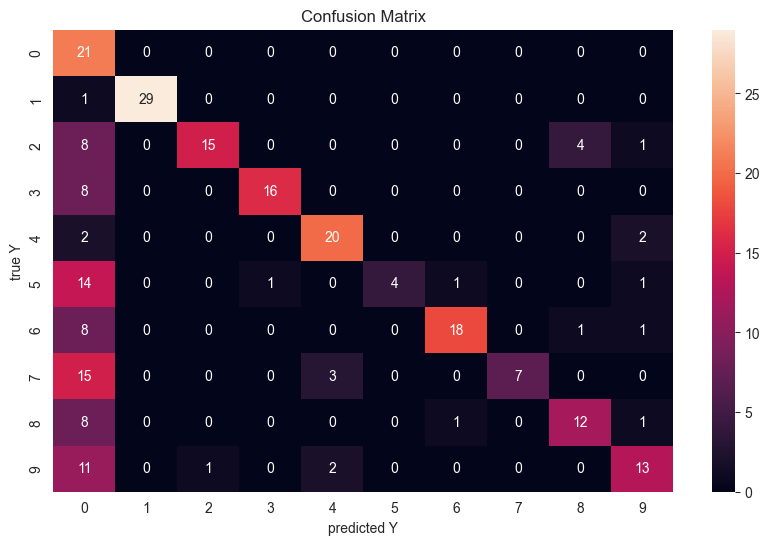

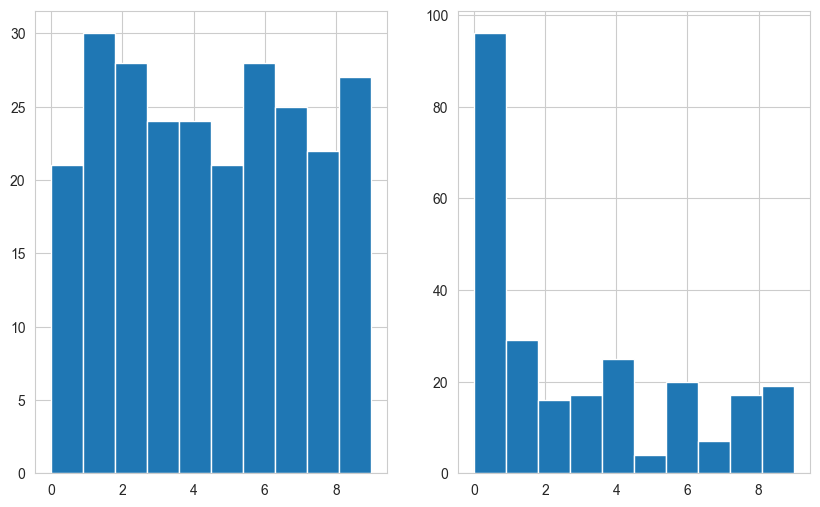

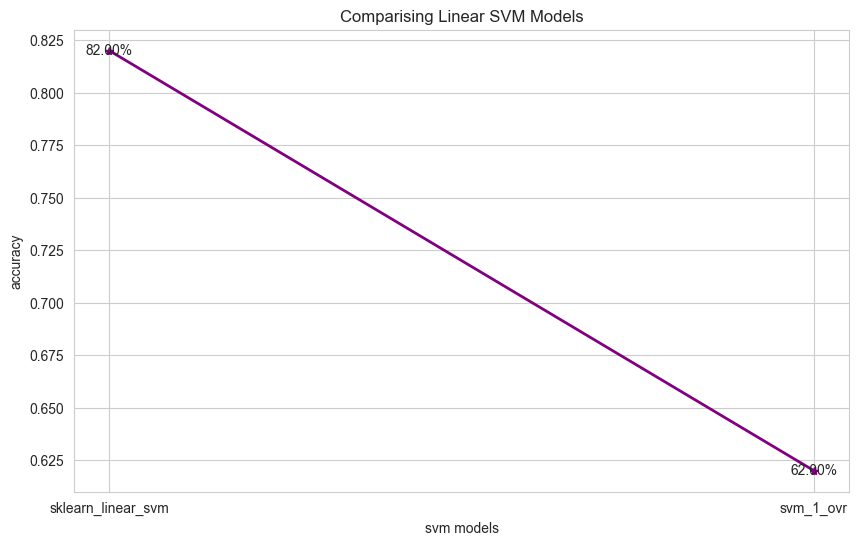

In [135]:
draw_confusion_matrix(Y_test,Y_pred_svm_1_ovr)
draw_distribution(Y_test,Y_pred_svm_1_ovr)
model_list = ['sklearn_linear_svm','svm_1_ovr']
model_accuracy_list = [sklearn_acc_linear,accuracy_svm_1_ovr]
draw_model_accuracy(model_list,model_accuracy_list)

## 3.2 SVM + one vs one策略
结果总结：当ovo策略的svm分类器优于ovr策略，但准确率与sklearn的svm分类器仍有差别，可能与其他参数有关。

In [136]:
# one vs one 策略
# 取出2个类别
def x_y_2(X_train, Y_train, i, j):
    x_pos = X_train[Y_train == i, :]
    y_pos = np.ones_like(Y_train[Y_train == i])
    x_neg = X_train[Y_train == j, :]
    y_neg = np.ones_like(Y_train[Y_train == j]) * -1
    return np.concatenate((x_pos, x_neg), axis=0), np.concatenate((y_pos, y_neg))

def train_ovo(xdata, ydata,c=0.6,toler=0.01,iter_max = 40):
    name_s = []
    alpha_s = []
    b_s = []
    svs_s = []
    sv_label_s = []
    sv_index_s = []
    for i in range(9):
        for j in range(i + 1, 10):
            x, y = x_y_2(xdata, ydata, i, j)
            # print(x,y)
            s_1 = SVM_1(x, y, c, toler,iter_max)
            b_al, alpha_al = s_1.smo_outer_loop()
            # print(alpha_al)
            sv_index = np.nonzero(s_1.alpha > 0)[0]
            # print(sv_index)
            svs = s_1.X[sv_index]
            # print(svs)
            sv_label = s_1.Y[sv_index]
            # print(sv_label)
            name_s.append([i, j])
            alpha_s.append(alpha_al)
            b_s.append(b_al)
            svs_s.append(svs)
            sv_label_s.append(sv_label)
            sv_index_s.append(sv_index)
    return name_s, alpha_s, b_s, svs_s, sv_label_s, sv_index_s

def test_ovo(x_test, y_test, name_s, alpha_s, b_s, svs_s, sv_label_s, sv_index_s):
    Y_pred = []
    error_count = 0
    for i in range(x_test.shape[0]):
        tmp_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for j in range(45):
            pos_int = name_s[j][0]
            neg_int = name_s[j][1]
            # print(name_s[j])
            kernel_val = np.dot(svs_s[j], x_test[i, :].T)
            # print('kernel_val',kernel_val,'sv_label',sv_label_s[j],'svm_1.alpha[sv_index]',alpha_s[j][sv_index_s[j]],'svm_1.b',b_s[j])
            predict_1 = np.dot(kernel_val.T, np.multiply(sv_label_s[j], alpha_s[j][sv_index_s[j]])) + b_s[j]
            # print(predict_1)
            if predict_1 > 0:
                tmp_list[pos_int] += 1
            elif predict_1 < 0:
                tmp_list[neg_int] += 1
            else:
                continue
        predict_max = 0
        int_max = 0
        for l in range(10):
            if tmp_list[l] > predict_max:
                predict_max = tmp_list[l]
                int_max = l
        if (int_max != y_test[i]):
            error_count = error_count + 1
        Y_pred.append(int_max)
    acc_1 = 1 - error_count / len(x_test)
    return acc_1, Y_pred

In [137]:
if __name__ == '__main__':
    start_time = time.time()
    name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_ovo(normalized_X_train,Y_train)
    accuracy_svm_1_ovo,Y_pred_svm_1_ovo = test_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    print(f"svm_1_ovo accuracy:{accuracy_svm_1_ovo*100:.2f}%")
    print(f"train dataset:{normalized_X_train.shape[0]},test dataset：{normalized_X_test.shape[0]},time:{time.time()-start_time}")

svm_1_ovo accuracy:81.60%
train dataset:750,test dataset：250,time:14.896726131439209


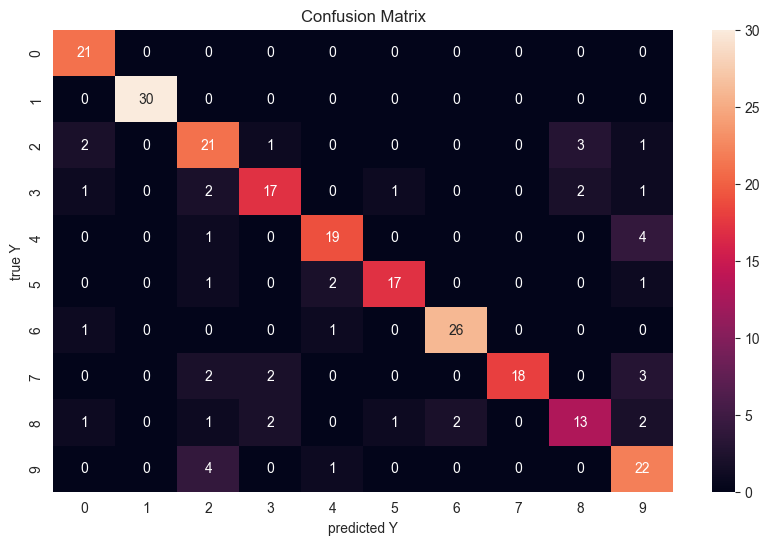

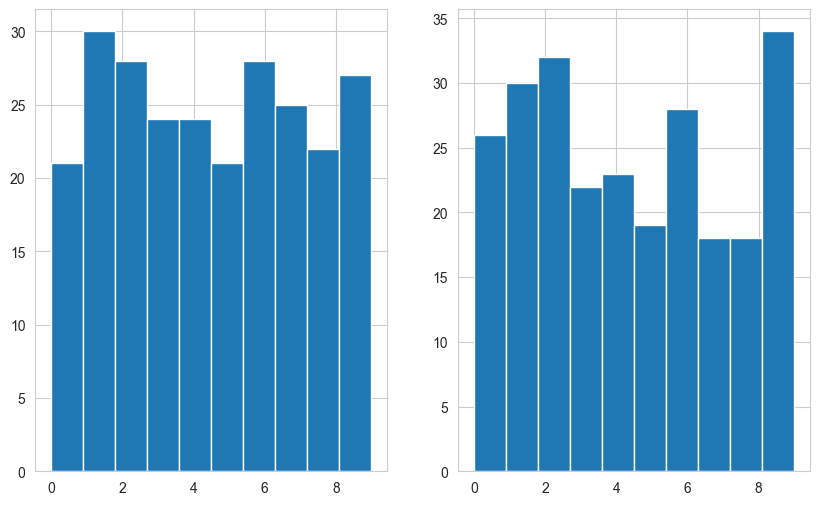

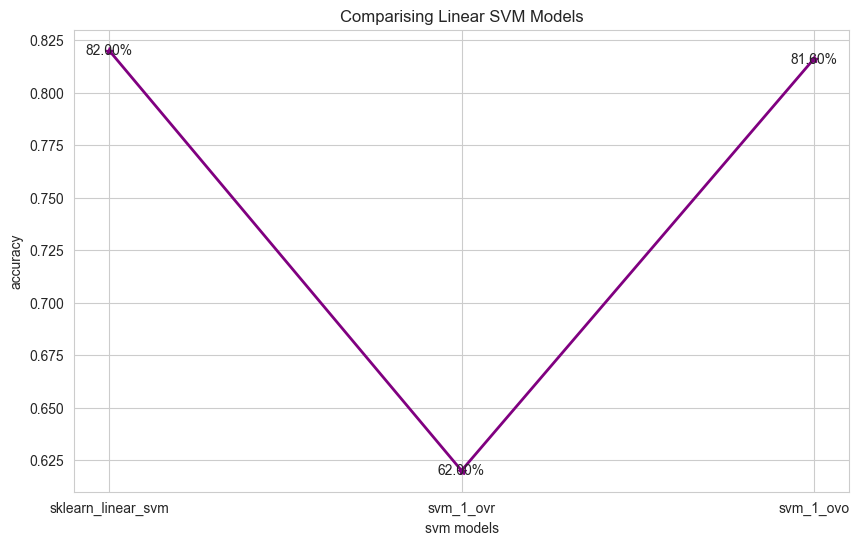

In [138]:
draw_confusion_matrix(Y_test,Y_pred_svm_1_ovo)
draw_distribution(Y_test,Y_pred_svm_1_ovo)
model_list = ['sklearn_linear_svm','svm_1_ovr','svm_1_ovo']
model_accuracy_list = [sklearn_acc_linear,accuracy_svm_1_ovr,accuracy_svm_1_ovo]
draw_model_accuracy(model_list,model_accuracy_list)

#### 总结：
结果总结：当数据集数量增加时，ovr策略的准确率下降.
结果总结：当ovo策略的svm分类器优于ovr策略，但准确率与sklearn的svm分类器仍有差别，可能与其他参数有关。

# 4 超参数搜索
1 使用基于ovo策略的SVM分类器进行超参数搜索：
主要搜索C、toler、max_iter三个参数。
2 使用sklearn的svm分类器进行超参数搜索：
主要搜索核函数类别和rbf核的gamma值两个参数。

## 4.1 基于ovo策略的SVM分类器

### 4.1.1 参数C

best c:0.1,accuracy:0.8240000000000001


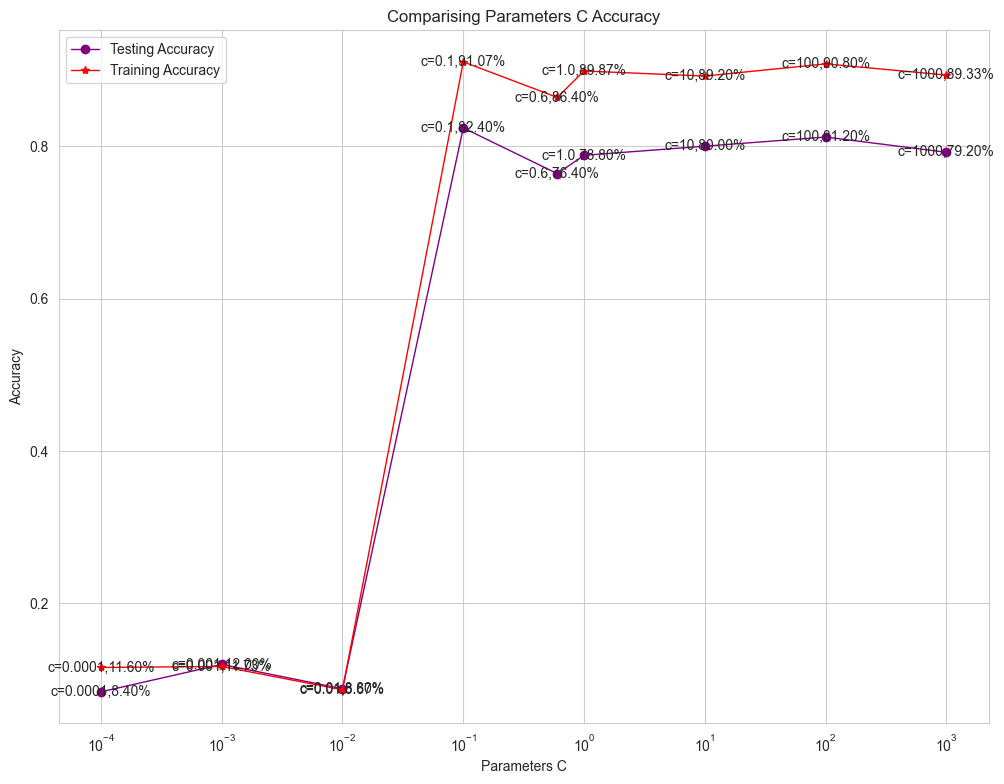

In [150]:
accuracy_test_s = []
accuracy_train_s = []
c_range = [0.0001,0.001,0.01,0.1,0.6,1.0,10,100,1000]
for c in c_range:
    name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_ovo(normalized_X_train,Y_train,c=c,toler=0.01,iter_max=40)
    acc_tr,pred_tr = test_ovo(normalized_X_train,Y_train,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    acc_test,pred_test = test_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    accuracy_train_s.append(acc_tr)
    accuracy_test_s.append(acc_test)
    
best_c = 0
best_acc = 0
for i in range(len(c_range)):
    if accuracy_test_s[i]>best_acc:
        best_c = c_range[i]
        best_acc = accuracy_test_s[i]
print(f'best c:{best_c},accuracy:{best_acc}')
    
    
plt.subplots(figsize = (12,9))
plt.semilogx(c_range,accuracy_test_s,color = 'purple',label = 'Testing Accuracy',linestyle = '-',marker = 'o',linewidth = 1)
plt.semilogx(c_range,accuracy_train_s,color = 'red',label = 'Training Accuracy',linestyle = '-',marker = '*',linewidth = 1)
plt.grid(True)
plt.xlabel('Parameters C')
for i,j in zip(c_range,accuracy_test_s):
    plt.text(i,j,f'c={i},{j*100:.2f}%',ha='center',va='center')
for i,j in zip(c_range,accuracy_train_s):
    plt.text(i,j,f'c={i},{j*100:.2f}%',ha='center',va='center')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparising Parameters C Accuracy')
plt.show()
    


### 4.1.2 参数toler

best toler:0.01,accuracy:0.8200000000000001


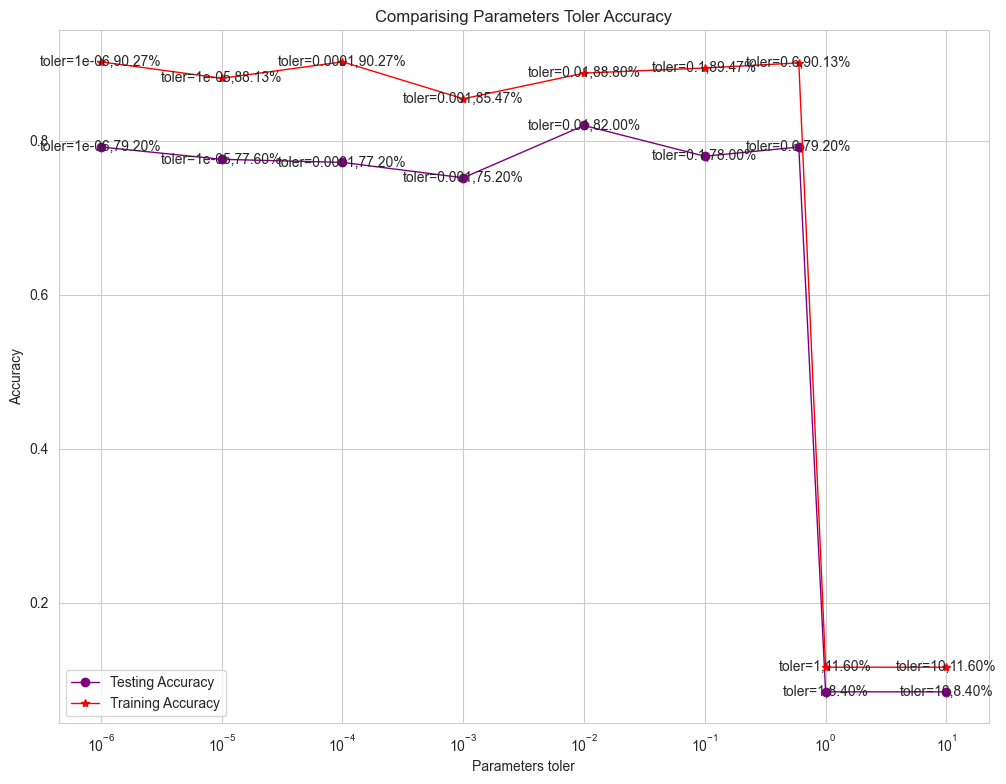

In [171]:
accuracy_test_s = []
accuracy_train_s = []
toler_range = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.6,1,10]
for tol in toler_range:
    sname_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_ovo(normalized_X_train,Y_train,c=best_c,toler=tol,iter_max=40)
    acc_tr,pred_tr = test_ovo(normalized_X_train,Y_train,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    acc_test,pred_test = test_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    accuracy_train_s.append(acc_tr)
    accuracy_test_s.append(acc_test)
   
best_tol = 0
best_acc = 0
for i in range(len(toler_range)):
    if accuracy_test_s[i]>best_acc:
        best_tol = toler_range[i]
        best_acc = accuracy_test_s[i]
print(f'best toler:{best_tol},accuracy:{best_acc}')

plt.subplots(figsize = (12,9))
plt.semilogx(toler_range,accuracy_test_s,color = 'purple',label = 'Testing Accuracy',linestyle = '-',marker = 'o',linewidth = 1)
plt.semilogx(toler_range,accuracy_train_s,color = 'red',label = 'Training Accuracy',linestyle = '-',marker = '*',linewidth = 1)
plt.grid(True)
plt.xlabel('Parameters toler')
for i,j in zip(toler_range,accuracy_test_s):
    plt.text(i,j,f'toler={i},{j*100:.2f}%',ha='center',va='center')
for i,j in zip(toler_range,accuracy_train_s):
    plt.text(i,j,f'toler={i},{j*100:.2f}%',ha='center',va='center')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparising Parameters Toler Accuracy')
plt.show()

### 4.1.3 参数iter_max

best iter:40,accuracy:0.8240000000000001


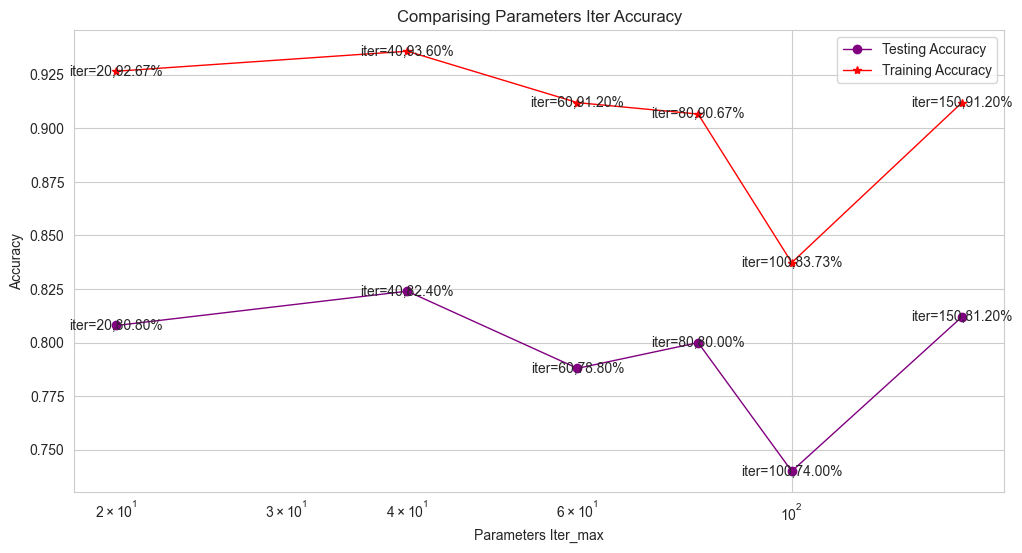

In [163]:
accuracy_test_s = []
accuracy_train_s = []
iter_range = [20,40,60,80,100,150]
for iter in iter_range:
    sname_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_ovo(normalized_X_train,Y_train,c=best_c,toler=best_tol,iter_max=iter)
    acc_tr,pred_tr = test_ovo(normalized_X_train,Y_train,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    acc_test,pred_test = test_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s)
    accuracy_train_s.append(acc_tr)
    accuracy_test_s.append(acc_test)
   
best_iter = 0
best_acc = 0
for i in range(len(iter_range)):
    if accuracy_test_s[i]>best_acc:
        best_iter = iter_range[i]
        best_acc = accuracy_test_s[i]
print(f'best iter:{best_iter},accuracy:{best_acc}')


plt.subplots(figsize = (12,6))
plt.xticks((range(20, 150, 10)))
plt.semilogx(iter_range,accuracy_test_s,color = 'purple',label = 'Testing Accuracy',linestyle = '-',marker = 'o',linewidth = 1)
plt.semilogx(iter_range,accuracy_train_s,color = 'red',label = 'Training Accuracy',linestyle = '-',marker = '*',linewidth = 1)
plt.grid(True)
plt.xlabel('Parameters Iter_max')
for i,j in zip(iter_range,accuracy_test_s):
    plt.text(i,j,f'iter={i},{j*100:.2f}%',ha='center',va='center')
for i,j in zip(iter_range,accuracy_train_s):
    plt.text(i,j,f'iter={i},{j*100:.2f}%',ha='center',va='center')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparising Parameters Iter Accuracy')
plt.show()

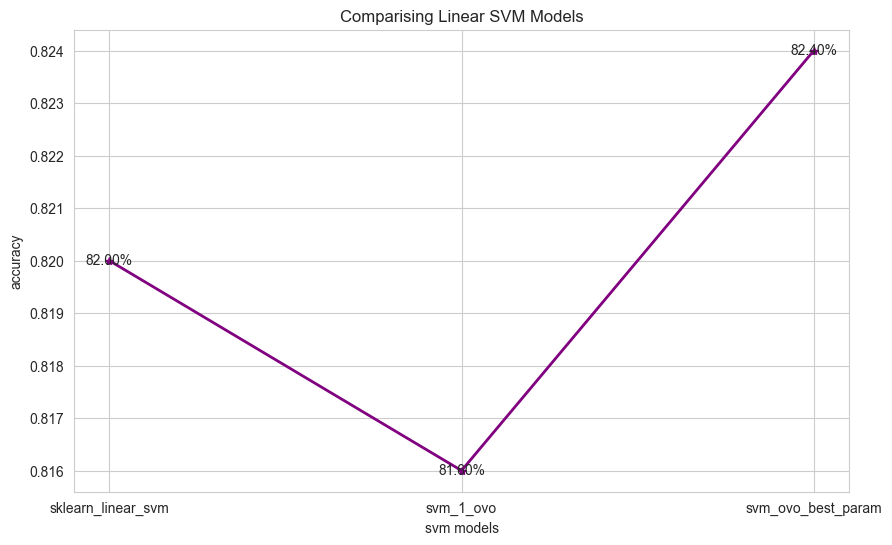

In [164]:
model_list = ['sklearn_linear_svm','svm_1_ovo','svm_ovo_best_param']
model_accuracy_list = [sklearn_acc_linear,accuracy_svm_1_ovo,best_acc]
draw_model_accuracy(model_list,model_accuracy_list)

实验结果表明：最优参数下的自己构建的ovo分类器可以达到更高准确率

## 4.2 对Scikit-learn的SVM分类器进行超参数搜索
### 4.2.1 核函数

rbf 0.908
sigmoid 0.828
linear 0.9
poly 0.856
best kernel:rbf


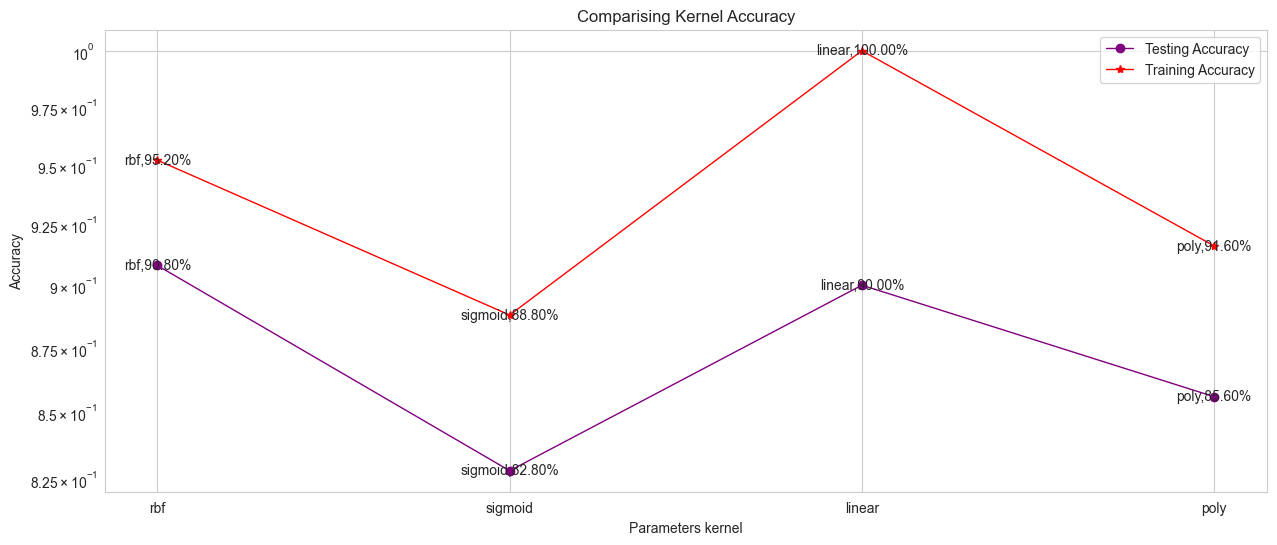

In [160]:
accuracy_test_s = []
accuracy_train_s = []
coefficient = []
kernel_range = ['rbf','sigmoid','linear','poly']
for knl in kernel_range:
    svm_k = svm.SVC(kernel=knl,gamma = 0.01,C = 0.6,degree = 1, probability = True,tol=0.001)
    svm_k.fit(normalized_X_train,Y_train)
    
    pred_tr = svm_k.predict(normalized_X_train)
    acc_tr = accuracy_score(Y_train,pred_tr)
    
    pred = svm_k.predict(normalized_X_test)
    acc_test = accuracy_score(Y_test,pred)
    accuracy_train_s.append(acc_tr)
    accuracy_test_s.append(acc_test)
    if acc_tr:
        print(knl,acc_test)
   
best_knl = ''
best_acc = 0
for i in range(len(kernel_range)):
    if accuracy_test_s[i]>best_acc:
        best_knl = kernel_range[i]
        best_acc = accuracy_test_s[i]
print(f'best kernel:{best_knl}')

plt.subplots(figsize = (15,6))
plt.semilogy(kernel_range,accuracy_test_s,color = 'purple',label = 'Testing Accuracy',linestyle = '-',marker = 'o',linewidth = 1)
plt.semilogy(kernel_range,accuracy_train_s,color = 'red',label = 'Training Accuracy',linestyle = '-',marker = '*',linewidth = 1,)
plt.grid(True)
plt.xlabel('Parameters kernel')
param_str = [str(knl) for knl in kernel_range]
param_list_x = [0,1,2,3]
plt.xticks(param_list_x,param_str,rotation = 0,ha = "center")
for i,j in zip(kernel_range,accuracy_test_s):
    plt.text(i,j,f'{str(i)},{j*100:.2f}%',ha='center',va='center')
for i,j in zip(kernel_range,accuracy_train_s):
    plt.text(i,j,f'{str(i)},{j*100:.2f}%',ha='center',va='center')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparising Kernel Accuracy')
plt.show()

### 4.2.2 rbf核函数的gamma

best gamma:0.1,best_acc


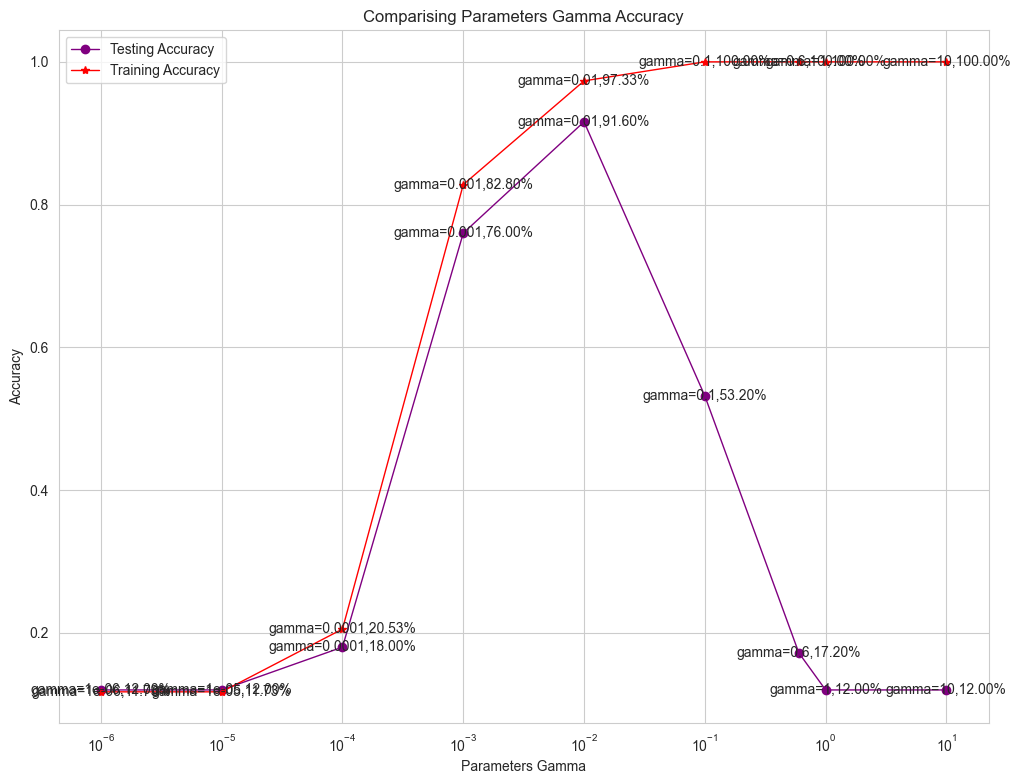

In [161]:
accuracy_test_s = []
accuracy_train_s = []
gamma_range = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.6,1,10]
for gamma in gamma_range:
    svm_t = svm.SVC(kernel = 'rbf',gamma = gamma)
    svm_t.fit(normalized_X_train,Y_train)
    
    pred_tr = svm_t.predict(normalized_X_train)
    acc_tr = accuracy_score(Y_train,pred_tr)
    
    pred = svm_t.predict(normalized_X_test)
    acc_test = accuracy_score(Y_test,pred)
    accuracy_train_s.append(acc_tr)
    accuracy_test_s.append(acc_test)
   
best_gamma = 0
best_acc = 0
for i in range(len(gamma_range)):
    if accuracy_test_s[i]>best_acc:
        best_gamma = gamma_range[i]
        best_acc = accuracy_test_s[i]
print(f'best gamma:{best_tol},best_acc')

plt.subplots(figsize = (12,9))
plt.semilogx(gamma_range,accuracy_test_s,color = 'purple',label = 'Testing Accuracy',linestyle = '-',marker = 'o',linewidth = 1)
plt.semilogx(gamma_range,accuracy_train_s,color = 'red',label = 'Training Accuracy',linestyle = '-',marker = '*',linewidth = 1)
plt.grid(True)
plt.xlabel('Parameters Gamma')
for i,j in zip(toler_range,accuracy_test_s):
    plt.text(i,j,f'gamma={i},{j*100:.2f}%',ha='center',va='center')
for i,j in zip(toler_range,accuracy_train_s):
    plt.text(i,j,f'gamma={i},{j*100:.2f}%',ha='center',va='center')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparising Parameters Gamma Accuracy')
plt.show()

# 5 构建使用核函数的SVM分类器

## 5.1 核转换函数

In [234]:
# 使用核函数
# 对sklearn的核函数
def kernel_trans(x,y,k_tup):
    m, n = np.shape(x)
    K = np.zeros((m))
    # 线性核函数 lin
    if k_tup[0] == 'lin':
        K = np.dot(x,y.T)
    # 高斯径向基核函数 rbf
    elif k_tup[0] == 'rbf':
        for j in range(m):
            delta_row = x[j, :] - y
            K[j] = np.dot(delta_row, delta_row.T)
            # print(j)
        K = np.exp(K / (-1 * k_tup[1] ** 2))
        # print(K)
    elif k_tup[0] == 'poly':
        K = np.dot(x, y.T) ** k_tup[1]
    else:
        raise NameError('Houston we Have a problem -- That Kernel is not recognized')
    return K

## 5.2 Sklearn SVM rbf核函数分类器

In [170]:
# 模型测试与评估（sklearn的svm分类器）
sklearn_rbf_svm = svm.SVC(kernel = 'rbf',gamma = 0.01,C=0.6,tol=0.01)
sklearn_rbf_svm.fit(normalized_X_train,Y_train)
y_pred_sklearn_rbf = sklearn_rbf_svm.predict(normalized_X_test)
sklearn_acc_rbf = accuracy_score(Y_test, y_pred_sklearn_rbf)
print(f'sklearn rbf kernel svm准确率:{sklearn_acc_rbf*100:.2f}%\n')

sklearn rbf kernel svm准确率:90.80%



## 5.3 带有核函数的SVM类

In [235]:
class SVM_1_Kernel:
    def __init__(self, X,Y,C=0.6,toler = 0.01,iter_max = 40,k_tup=('rbf',0.01)):
        self.C = C # 惩罚参数
        self.b = 0
        self.X = X
        self.Y = Y
        self.toler = toler # 松弛因子
        self.m = X.shape[0] # 训练集数
        self.n = X.shape[1] # 特征数
        self.alpha = np.zeros(self.m)
        self.e_cache = np.zeros((self.m,2)) # 初始化E
        self.iter_max = iter_max
        self.K = np.zeros((self.m,self.m))
        self.w = np.zeros(self.n)
        self.k_tup = k_tup
        for i in range(self.m):
            self.K[:,i] = kernel_trans(self.X,self.X[i,:],k_tup)
        
        
    def cal_Ek(self,i):
        # ei = g(xi)-yi
        k_i= kernel_trans(self.X,self.X[i],self.k_tup)
        fxk_pred = np.dot((self.alpha*self.Y).T,k_i.T)+self.b
        E_i = fxk_pred-self.Y[i]
        # print(E_i)
        return E_i
    
    
    def select_j(self,i,Ei):
        max_k = -1
        max_delta_e = 0
        Ej = 0
        self.e_cache[i] = [1,Ei]
        valid_e_cache_list = np.nonzero(self.e_cache[:,0])[0]
        if len(valid_e_cache_list) > 1:
            for k in valid_e_cache_list:
                if k == i:
                    continue
                Ek = self.cal_Ek(k)
                delta_e = abs(Ei - Ek)
                # 寻找｜E1-E2｜最大的第二个alpha
                if (delta_e>max_delta_e):
                    # 更新最大值
                    max_delta_e = delta_e
                    max_k = k
                    Ej = Ek
            return max_k,Ej
        else:
            j = select_jrand(i,self.m)
            Ej = self.cal_Ek(j)
        return j,Ej
                    
    def update_ek(self,k):
        Ek = self.cal_Ek(k)
        # print(1,Ek)
        self.e_cache[k] = [1,Ek]
        
    def inner_loop(self,i):
        Ei = self.cal_Ek(i)
        # print('Ei:',Ei,'\n','Yi:',self.Y[i],'\n','alphai:',self.alpha[i])
        if ((self.Y[i]*Ei < -self.toler) and (self.alpha[i]<self.C)) or ((self.Y[i]*Ei>self.toler) and (self.alpha[i]>0)):
            j,Ej = self.select_j(i,Ei)
            alpha_i_old = self.alpha[i].copy()
            alpha_j_old = self.alpha[j].copy()
            # L与H是alpha_j_new所在对角线端点界
            if (self.Y[i] != self.Y[j]):
                # 如果yi ！= yj
                L = max(0,self.alpha[j]-self.alpha[j])
                H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
            else:
                # 如果yi= yj
                L = max(0,self.alpha[j]+self.alpha[i]-self.C)
                H = min(self.C,self.alpha[i]+self.alpha[j])
            if L == H:
                # print('L == H')
                return 0
            eta = 2.0*self.K[i,j]-self.K[i,i]-self.K[j,j]
            if eta >= 0:
                # print('eta >= 0')
                return 0
            self.alpha[j] -= (self.Y[j]*(Ei-Ej))/eta
            self.alpha[j] = clip_alpha(self.alpha[j],H,L)
            self.update_ek(j)
            if(abs(self.alpha[j]-alpha_j_old)<0.001):
                # print("j not moving enough")
                return 0
            self.alpha[i] += self.Y[j]*self.Y[i]*(alpha_j_old-self.alpha[j])
            self.update_ek(i)
            
            b1 = self.b - Ei - self.Y[i]*(self.alpha[i]-alpha_i_old)*self.K[i,i]-self.Y[j]*(self.alpha[j]-alpha_j_old)*self.K[i,j]
            b2 = self.b - Ei - self.Y[i]*(self.alpha[i]-alpha_i_old)*self.K[i,j] - self.Y[j]*(self.alpha[j]-alpha_j_old)*self.K[j,j]
            
            if (0<self.alpha[i])and (self.alpha[i]<self.C):
                self.b = b1
            elif (0<self.alpha[j])and (self.alpha[j]<self.C):
                self.b = b2
            else:
                self.b = (b1+b2)/2
                
            for nn in range(self.n):
                self.w[nn] += np.sum(self.alpha*self.Y*self.X[:,nn])
            return 1
        else:
            return 0   
           
    
    def smo_outer_loop(self):
        iter_count = 0
        alpha_pairs_changed = 0
        entire_set = True
        while(iter_count<self.iter_max)and((alpha_pairs_changed>0)or(entire_set)):
            alpha_pairs_changed = 0
            if entire_set:
                for i in range(self.m):
                    alpha_pairs_changed += self.inner_loop(i)
                # print(f'fullSet,iter:{iter_count},i:{i},pairs_changedL{alpha_pairs_changed}')
                iter_count+=1
            else:
                non_bound_is = np.nonzero((self.alpha>0)*(self.alpha<self.C))[0]
                for i in non_bound_is:
                    alpha_pairs_changed += self.inner_loop(i)
                    # print(f'non-bound,iter:{iter_count},i:{i},pairs_changedL{alpha_pairs_changed}')
                iter_count += 1
            if entire_set:
                entire_set = False
            elif alpha_pairs_changed == 0:
                entire_set = True
            # print(f'iteration number:{iter_count}')
        return self.b,self.alpha
    
    def cal_ws(self):
        for i in range(self.m):
            self.w += np.multiply(np.dot(self.alpha[i],self.Y[i]),self.X[i,:].T)
        return self.w
    
    def pred(self,x_test_i):
        pred_res = np.sign(np.dot(self.w,x_test_i)+self.b)
        return pred_res

## 5.4 ovo策略

In [193]:
# 取出2个类别
def x_y_2(X_train,Y_train,i,j):
    x_pos = X_train[Y_train==i,:]
    y_pos = np.ones_like(Y_train[Y_train==i])
    x_neg = X_train[Y_train==j,:]
    y_neg = np.ones_like(Y_train[Y_train==j])*-1
    return np.concatenate((x_pos,x_neg),axis=0),np.concatenate((y_pos,y_neg))

In [236]:
def train_kernel_ovo(xdata,ydata,k_tup):
    name_s = []
    alpha_s = []
    b_s = []
    svs_s = []
    sv_label_s = []
    sv_index_s = []
    for i in range(9):
        for j in range(i+1,10):
            x,y = x_y_2(xdata,ydata,i,j)
            # print(x,y)
            s_1 = SVM_1_Kernel(x,y,0.6,0.01,70,k_tup)
            b_al,alpha_al = s_1.smo_outer_loop()
            # print(alpha_al)
            sv_index = np.nonzero(s_1.alpha>0)[0]
            # print(sv_index)
            svs = s_1.X[sv_index]
            # print(svs)
            sv_label = s_1.Y[sv_index]
            # print(sv_label)
            name_s.append([i,j])
            alpha_s.append(alpha_al)
            b_s.append(b_al)
            svs_s.append(svs)
            sv_label_s.append(sv_label)
            sv_index_s.append(sv_index)
    return name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s

In [199]:
def test_kernel_ovo(x_test,y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s,k_tup):
    Y_pred = []
    error_count = 0
    for i in range(x_test.shape[0]):
        tmp_list = [0,0,0,0,0,0,0,0,0,0]
        for j in range(45):
            pos_int = name_s[j][0]
            neg_int = name_s[j][1]
            # print(name_s[j])
            kernel_val = kernel_trans(svs_s[j],x_test[i,:],k_tup)
           # print('kernel_val',kernel_val,'sv_label',sv_label_s[j],'svm_1.alpha[sv_index]',alpha_s[j][sv_index_s[j]],'svm_1.b',b_s[j])
            predict_1 = np.dot(kernel_val.T,np.multiply(sv_label_s[j],alpha_s[j][sv_index_s[j]]))+b_s[j]
            print(predict_1)
            if predict_1 > 0:
                tmp_list[pos_int] += 1
            elif predict_1 < 0:
                tmp_list[neg_int] += 1
            else:
                continue
        predict_max= 0
        int_max = 0
        for l in range(10):
            if tmp_list[l] > predict_max:
                predict_max = tmp_list[l]
                int_max = l
        if(int_max!=y_test[i]):
            error_count = error_count + 1
        Y_pred.append(int_max)
    acc_1 = 1-error_count/len(x_test)
    return acc_1,Y_pred

## 5.5 分类与比较
### 5.5.1 lin 线性核

In [200]:
if __name__ == '__main__':
    start_time = time.time()
    name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_kernel_ovo(normalized_X_train,Y_train,('lin',0.1))
    accuracy_svm_kernel_lin_ovo,Y_pred_kernel_lin_ovo = test_kernel_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s,('lin',0.1))
    print(f"svm_lin_kernel accuracy:{accuracy_svm_kernel_lin_ovo*100:.2f}%")
    print(f"train dataset:{normalized_X_train.shape[0]},test dataset：{normalized_X_test.shape[0]},time:{time.time()-start_time}")

0.25188960961712126
-1.501897296731441
0.5959771761342778
-0.2415191142330677
0.5327616969850408
-0.6734649260076886
0.8798178694419325
-0.14395429479563193
0.4290338574022385
-2.167303868886872
-1.021271381103185
-0.5079827922383526
-1.6957443555851852
-0.25926916885516493
-1.7561799495897035
-1.6586159646254948
-0.4266360176074083
1.3948852326809575
2.2647596356653272
1.8000905017286406
2.3642305650691444
1.7065566270122443
1.6624967037121645
1.087510033617146
0.5767553339870981
0.18888030662662064
0.23279273873524936
-1.1081297705965742
-0.3673917307650192
-0.7463988688485275
-0.5065364949095006
-0.5948263827390085
-1.2390885340555342
-2.300611962916663
-1.0815261832247396
-1.1492093046661815
-0.09018706073589786
-1.8931438771700688
-0.6714737495940817
1.009640226233491
-0.8190222950253779
-0.04840148657458121
-0.016301554434755783
0.33834831302902235
0.23099687298339877
-0.24035236695184392
0.6332136885859807
0.1652467186214463
-0.11566747080157636
-0.5575310157722222
-0.3539445673

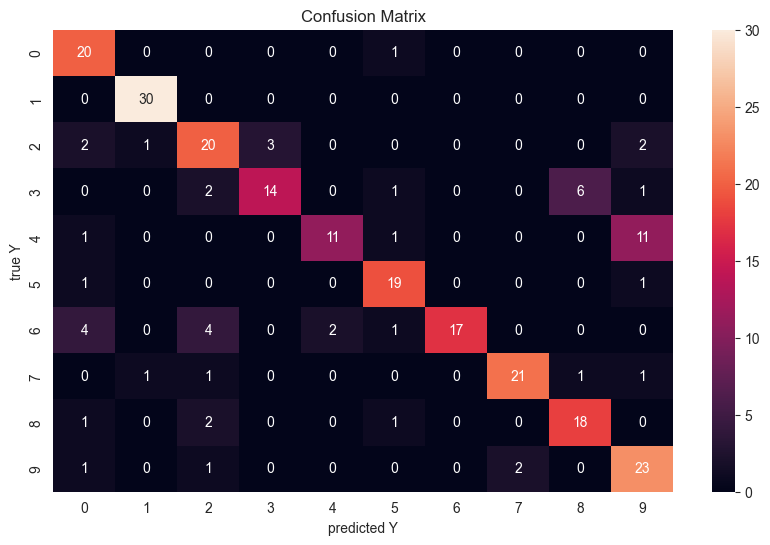

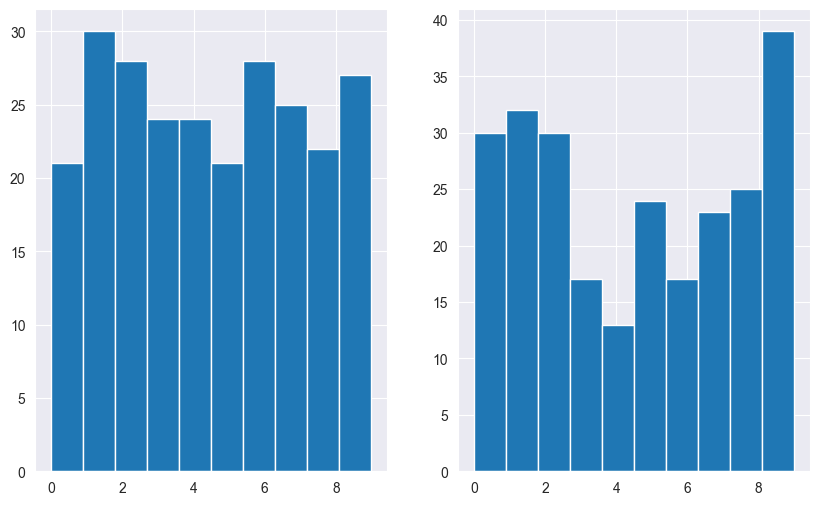

In [99]:
draw_confusion_matrix(Y_test,Y_pred_kernel_lin_ovo)
draw_distribution(Y_test,Y_pred_kernel_lin_ovo)

### 5.5.2 rbf 高斯径向基核函数

In [237]:
if __name__ == '__main__':
    start_time = time.time()
    name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s = train_kernel_ovo(normalized_X_train,Y_train,('rbf',0.01))
    accuracy_svm_kernel_rbf_ovo,Y_pred_kernel_rbf_ovo = test_kernel_ovo(normalized_X_test,Y_test,name_s,alpha_s,b_s,svs_s,sv_label_s,sv_index_s,('rbf',0.01))
    print(f"svm_1_kernel accuracy:{accuracy_svm_kernel_rbf_ovo*100:.2f}%")
    print(f"train dataset:{normalized_X_train.shape[0]},test dataset：{normalized_X_test.shape[0]},time:{time.time()-start_time}")

-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
1.0
1.0
1.0
-0.9999999999999999
-0.9999999999999999
1.0
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
1.0
1.0
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
1.0
1.0
1.0
-0.9999999999999999
-0.9999999999999999
1.0
1.0
-0.9999999999999999
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
-0.9999999999999999
1.0
-0.9999999999999999
-0.99999

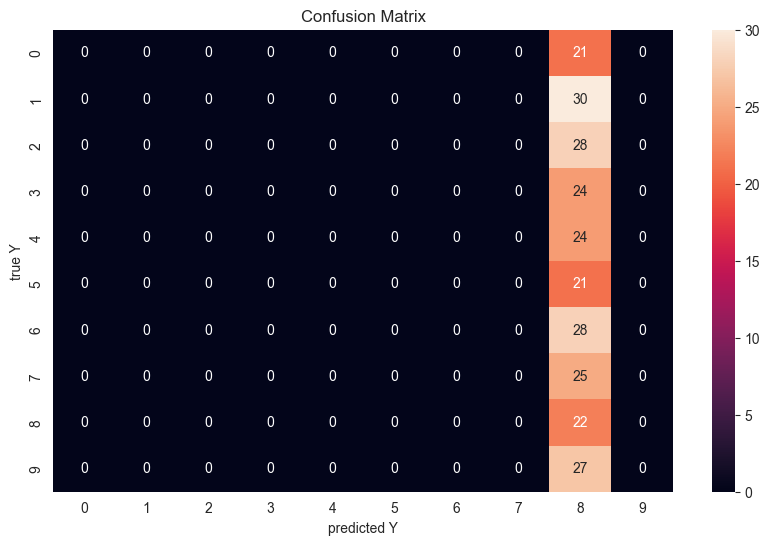

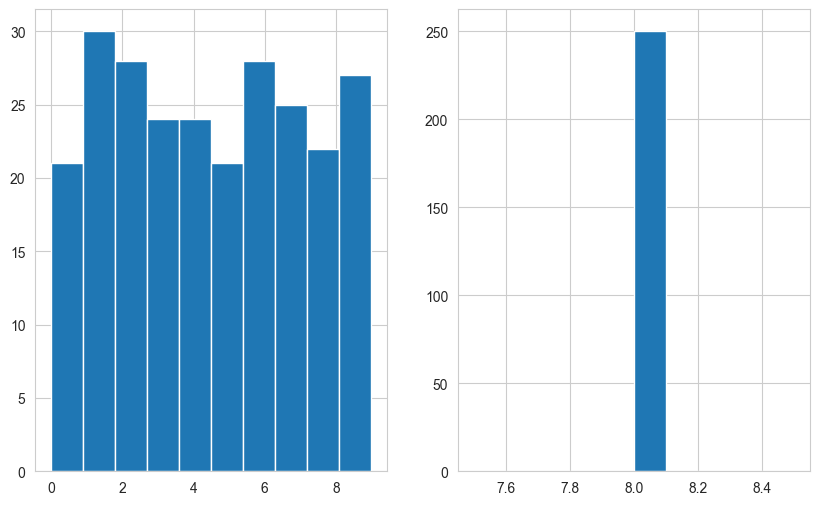

In [238]:
draw_confusion_matrix(Y_test,Y_pred_kernel_rbf_ovo)
draw_distribution(Y_test,Y_pred_kernel_rbf_ovo)

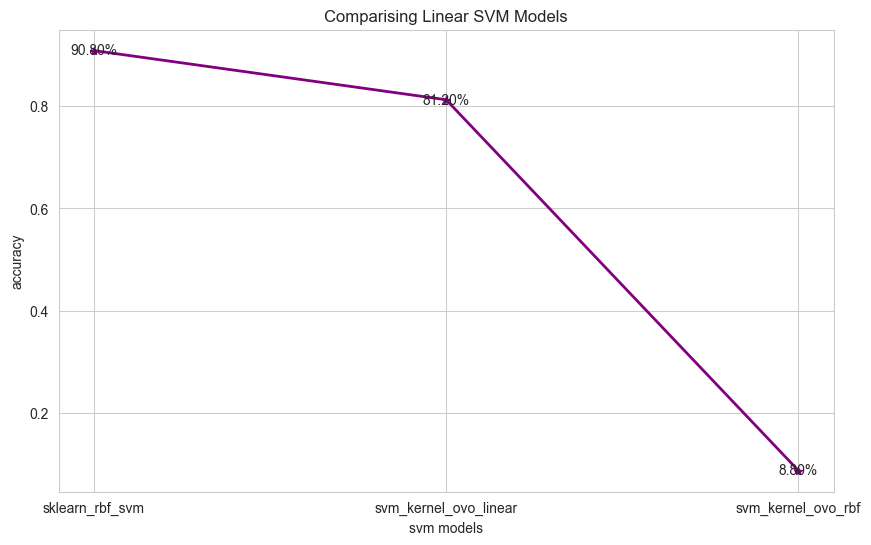

In [254]:
model_list = ['sklearn_rbf_svm','svm_kernel_ovo_linear','svm_kernel_ovo_rbf']
model_accuracy_list = [sklearn_acc_rbf,accuracy_svm_kernel_lin_ovo,accuracy_svm_kernel_rbf_ovo]
draw_model_accuracy(model_list,model_accuracy_list)

总结：尝试构建核函数，但使用非linear核函数时遇到了问题。

# 6 比较使用kernel的SVM分类器与不使用kernel的SVM分类器（可视化降维后的分类界面）

## 6.1 Sklearn SVM 线性核函数分类界面

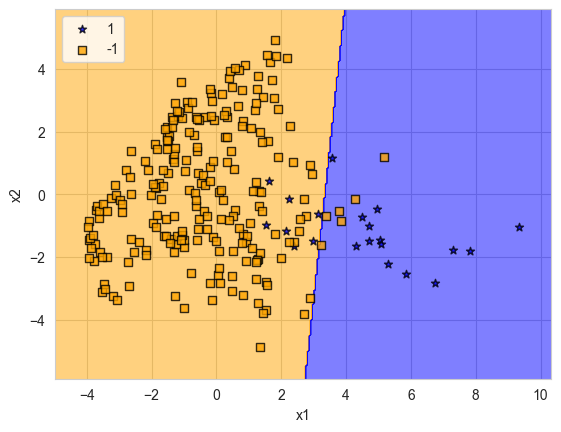

In [251]:
colors = ('orange','blue')
cmap = ListedColormap(colors)
# PCA降维
pca_tr = PCA(n_components=2)
pca_tr.fit(normalized_X_train)
x_tr = pca_tr.transform(normalized_X_train)
pca_test = PCA(n_components=2)
pca_test.fit(normalized_X_test)
x_test = pca_test.transform(normalized_X_test)
# 绘制Sklearn SVM 线性核函数分类界面
model = svm.LinearSVC(C=10,dual=False)
model.fit(x_tr,Y_train_binary)

x1_min,x1_max = x_test[:,0].min()-1,x_test[:,0].max()+1
x2_min,x2_max = x_test[:,1].min()-1,x_test[:,1].max()+1
xx_1,xx_2 = np.meshgrid(np.arange(x1_min,x1_max,0.05),np.arange(x2_min,x2_max,0.05))  
Z = model.predict(np.array([xx_1.ravel(),xx_2.ravel()]).T)
Z = Z.reshape(xx_1.shape)

plt.contourf(xx_1,xx_2,Z,alpha=0.5,cmap = cmap)
plt.xlim(xx_1.min(),xx_1.max())
plt.ylim(xx_2.min(),xx_2.max())

plt.scatter(x = x_test[Y_test_binary == 1,0],y = x_test[Y_test_binary==1,1],alpha=0.8,marker = '*',label=1,c = 'blue',edgecolors='black')
plt.scatter(x = x_test[Y_test_binary ==-1,0],y = x_test[Y_test_binary==-1,1],alpha=0.8,marker = 's',label=-1,c = 'orange',edgecolors='black')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')

plt.show()

## 6.2 Sklearn SVM rbf核函数分类界面

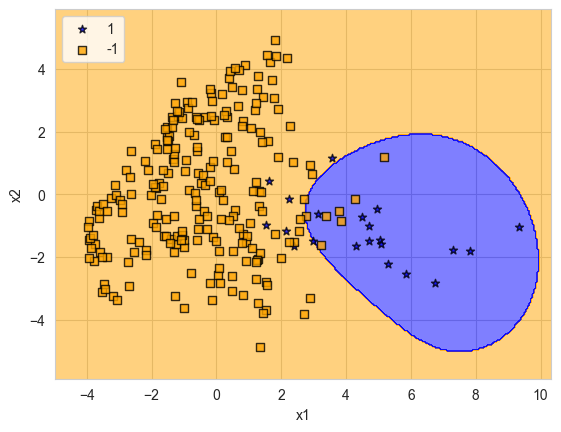

In [253]:
# 绘制Sklearn SVM rbf核函数分类界面
model = svm.SVC(kernel = 'rbf')
model.fit(x_tr,Y_train_binary)

x1_min,x1_max = x_test[:,0].min()-1,x_test[:,0].max()+1
x2_min,x2_max = x_test[:,1].min()-1,x_test[:,1].max()+1
xx_1,xx_2 = np.meshgrid(np.arange(x1_min,x1_max,0.05),np.arange(x2_min,x2_max,0.05))  
Z = model.predict(np.array([xx_1.ravel(),xx_2.ravel()]).T)
Z = Z.reshape(xx_1.shape)

plt.contourf(xx_1,xx_2,Z,alpha=0.5,cmap = cmap)
plt.xlim(xx_1.min(),xx_1.max())
plt.ylim(xx_2.min(),xx_2.max())

plt.scatter(x = x_test[Y_test_binary == 1,0],y = x_test[Y_test_binary==1,1],alpha=0.8,marker = '*',label=1,c = 'blue',edgecolors='black')
plt.scatter(x = x_test[Y_test_binary ==-1,0],y = x_test[Y_test_binary==-1,1],alpha=0.8,marker = 's',label=-1,c = 'orange',edgecolors='black')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')

plt.show()

区别：线性核函数（不使用核函数）的分类界面是直线，rbf核函数分类界面是曲线